In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("/data/tim/heronWorkspace/src")
sys.path.append("/data/tim/heronWorkspace/0_preProcessing")
sys.path.append("/data/tim/heronWorkspace/1_AE")
sys.path.append("/data/tim/heronWorkspace/2_postProcessing")
sys.path.append("/data/tim/heronWorkspace/")


from AEHeronModelV1 import AEHeronModel
from AEHeronModelV2 import CAEHeron
from lightning.pytorch.callbacks import ModelSummary
from torchsummary import summary
import HeronImageLoader
from torch.utils.data import DataLoader, BatchSampler
from matplotlib import pyplot as plt
import lightning.pytorch as pl
from lightning.pytorch.tuner import Tuner
import pandas as pd
from lightning.pytorch.loggers import CSVLogger
from models import MLPBasic, CAEBigBottleneck, CAESmallBottleneckWithLinear, MLPBasicHeatMap, CAEV1
import numpy as np
import torch.nn.functional as F
import torch
from torchvision.transforms import GaussianBlur
from PIL import Image, ImageFilter
import random
from scipy.stats import loguniform
from ClassifierDatasets import DatasetThreeConsecutive, UnNormalize
# from torchmetrics.image import StructuralSimilarityIndexMeasure
from skimage.metrics import structural_similarity as ssim
import seaborn as sns
from sklearn.model_selection import ParameterSampler
from scipy.stats import loguniform
import functorch
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve

colors = [
    "#32829C",
    "#E38538",
    "#51AC8C",
    "#D94841",
    "#7A5C96"
]
sns.set_palette(sns.color_palette(colors))
sns.set_style("whitegrid")

In [2]:

def min_filter(tensor : torch.Tensor, kernel_size=3):
    # Unfold the tensor into sliding local blocks
    unfolded = tensor.unfold(0, kernel_size, 1)
    unfolded = unfolded.unfold(1, kernel_size, 1)
    # Compute the minimum in each of these blocks
    return unfolded.min(dim=-1)[0].min(dim=-1)[0]

In [3]:
model = CAEV1

checkPoint = '/data/tim/heronWorkspace/logs/CAEV1/version_3/checkpoints/epoch=49-step=19350.ckpt'
caeLoaded = CAEHeron.load_from_checkpoint(checkPoint, model = model)
caeLoaded.freeze()

/home/tim/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/tim/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:740: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 803: system has unsupported display driver / cuda driver combination (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() if nvml_count < 0 else nvml_count


# different zeroThreshold and sumThreshold

In [4]:
def computeSumDifferentThresholds(params: dict, loaderParams: dict, zeroThresholdArr: np.array, checkPoint = None):
    unnorm = UnNormalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    if checkPoint is None:
        checkPoint = '/data/tim/heronWorkspace/logs/CAEV1/version_3/checkpoints/epoch=49-step=19350.ckpt'
    caeLoaded = CAEHeron.load_from_checkpoint(checkPoint, model = model)
    caeLoaded.freeze()
  
    
    dataset = DatasetThreeConsecutive(cameras=params["cameras"], resize_to=CAEV1.imsize, **loaderParams)
    print(f'Length of dataset: {len(dataset)}')
    print(params)
    dataLoader = DataLoader(dataset, batch_size=8, shuffle=False, num_workers=2)

    blur = GaussianBlur(kernel_size=params["gaussianFilterSize"], sigma=params["gaussianFilterSigma"]) #TODO: make this a parameter
    lossFn = F.mse_loss if params["lossFn"] == "MSE" else F.l1_loss
    sumVals = []
    lblVals = []

    for (imArr, lblArr, camera, ImagePath) in dataLoader:

        isTrainingCamera = camera in caeLoaded.hparams.cameras
        prevImg = imArr[0] #alwasy #batch_size images
        currImg = imArr[1]
        nextImg = imArr[2]

        prevPred, currPred, nextPred = [unnorm(caeLoaded(x.to(caeLoaded.device))) for x in [prevImg, currImg, nextImg]]
        prevImg, currImg, nextImg = [unnorm(x) for x in [prevImg, currImg, nextImg]]


        prevImgBlurred, currImgBlurred, nextImgBlurred = [blur.forward(x).to(prevPred.device) for x in [prevImg, currImg, nextImg]]
    
        
        prevImd, currImd, nextImd = [torch.sum(lossFn(imgBlurred, pred, reduction='none'), dim=1) for imgBlurred, pred in zip([prevImgBlurred, currImgBlurred, nextImgBlurred], [prevPred, currPred, nextPred])]

        prevToCurrImd = torch.clamp(torch.sub(currImd, prevImd), min= 0)
        nextToCurrImd = torch.clamp(torch.sub(currImd, nextImd), min= 0)

        prevNextCurrImd = torch.div(torch.add(prevToCurrImd, nextToCurrImd), 2)

        prevNextCurrImdMin = torch.stack([min_filter(x, kernel_size=params["minFilterKernelSize"]) for x in prevNextCurrImd]) #TODO: evtl make this as before
        

        # prevNextCurrImdMinThresh = torch.where(prevNextCurrImdMin < params["zeroThreshold"], torch.zeros_like(prevNextCurrImdMin), prevNextCurrImdMin)
        sumZeroThresholdArr = [torch.sum(torch.where(prevNextCurrImdMin < zeroThreshold, torch.zeros_like(prevNextCurrImdMin), prevNextCurrImdMin), dim=(1, 2)).numpy(force=True) for zeroThreshold in zeroThresholdArr]
        sumZeroThresholdArr = np.array(sumZeroThresholdArr) # shape: (len(zeroThresholdArr), batch_size)

        
        # sumPrevNextCurrImdMin = torch.sum(prevNextCurrImdMinThresh, dim=(1, 2))
        # predictions = (sumPrevNextCurrImdMin> params["sumThreshold"]).to(torch.int)

        for i in range(sumZeroThresholdArr.shape[1]):
            sumVals.append(sumZeroThresholdArr[:, i])
            lblVals.append(lblArr[i].item())
    
        # imagePaths += list(ImagePath)
    
    
    return np.array(sumVals), np.array(lblVals)





In [ ]:
loaderParams = dict(
    lblValidationMode = "Manual",
    balanced = True,
    anomalyObviousness = "obvious",
    distinctCAETraining = False,
    colorMode = "RGB",
    random_state = 1,
    set = "train"
)
startState = dict(
    cameras = ["NEN1", "SBU3"], #, ["SBU4"]
    balanced = True,
    distinctCAETraining = False,
    gaussianFilterSize = 5,
    gaussianFilterSigma = 5,
    filter = "MinFilter", #["MinFilter", "GaussianFilter"]
    minFilterKernelSize = 4,
    # zeroThreshold = 0.175, # uniform dist on loc, loc+scale -> uniform(loc, scale) #threshold for zeroing out the image
    # sumThreshold = 50.9,
    lossFn = "L1"
)

zeroThresholdArr = np.arange(start=0.1, stop = 0.5, step=0.1) # uniform dist on loc, loc+scale -> uniform(loc, scale) #threshold for zeroing out the image
sumThresholdArr = np.arange(start=5, stop=100, step=10)

sumVals, lblVals = computeSumDifferentThresholds(params=startState, loaderParams=loaderParams, zeroThresholdArr=zeroThresholdArr)


# ROC

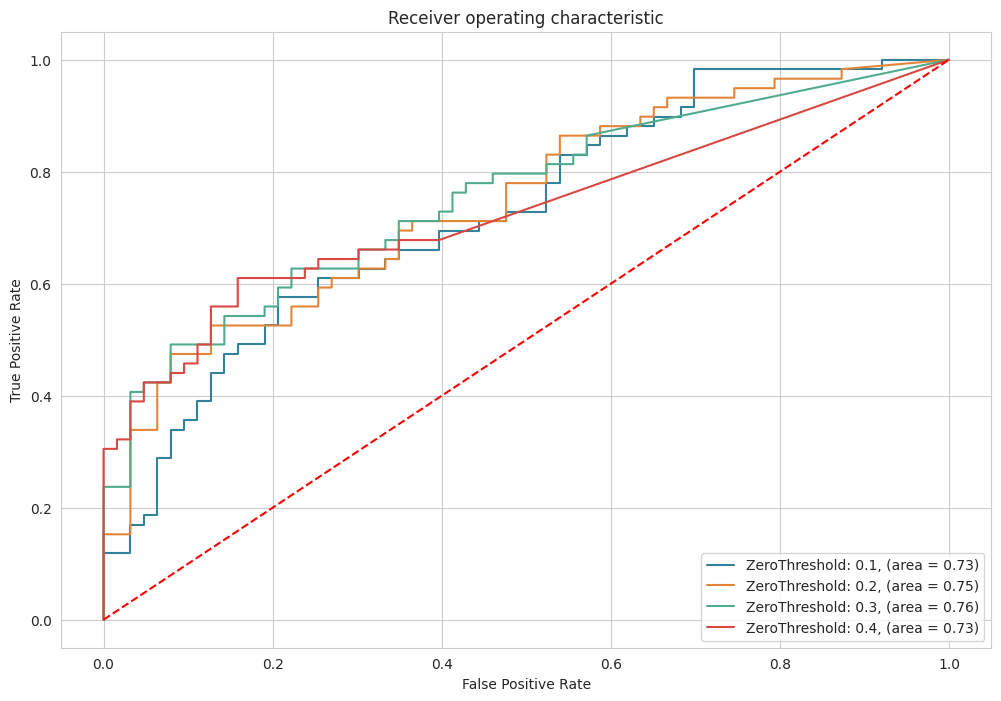

In [6]:
plt.figure(figsize = (12,8)) 
for i in range (zeroThresholdArr.shape[0]):
    fpr, tpr, thresholds = roc_curve(lblVals, sumVals[:, i])
    roc_auc = roc_auc_score(lblVals, sumVals[:, i])
    plt.plot(fpr, tpr, label=f'ZeroThreshold: {zeroThresholdArr[i]:0.1f}, (area = {roc_auc:0.2f})')

plt.plot([0, 1], [0, 1],'r--') 
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.title('Receiver operating characteristic') 
plt.legend(loc="lower right") 
plt.show()

# Precision/Recall

In [8]:
loaderParams = dict(
    lblValidationMode = "Manual",
    balanced = False,
    anomalyObviousness = "obvious",
    distinctCAETraining = False,
    colorMode = "RGB",
    random_state = 1,
    set = "train"
)
startState = dict(
    cameras = ["NEN1", "SBU3"], #, ["SBU4"]
    distinctCAETraining = False,
    gaussianFilterSize = 5,
    gaussianFilterSigma = 5,
    filter = "MinFilter", #["MinFilter", "GaussianFilter"]
    minFilterKernelSize = 4,
    # zeroThreshold = 0.175, # uniform dist on loc, loc+scale -> uniform(loc, scale) #threshold for zeroing out the image
    # sumThreshold = 50.9,
    lossFn = "L1"
)

zeroThresholdArr = np.arange(start=0.1, stop = 0.5, step=0.1) # uniform dist on loc, loc+scale -> uniform(loc, scale) #threshold for zeroing out the image
sumThresholdArr = np.arange(start=5, stop=100, step=10)

sumVals, lblVals = computeSumDifferentThresholds(params=startState, loaderParams=loaderParams, zeroThresholdArr=zeroThresholdArr)

Length of dataset: 581
{'cameras': ['NEN1', 'SBU3'], 'distinctCAETraining': False, 'gaussianFilterSize': 5, 'gaussianFilterSigma': 5, 'filter': 'MinFilter', 'minFilterKernelSize': 4, 'lossFn': 'L1'}


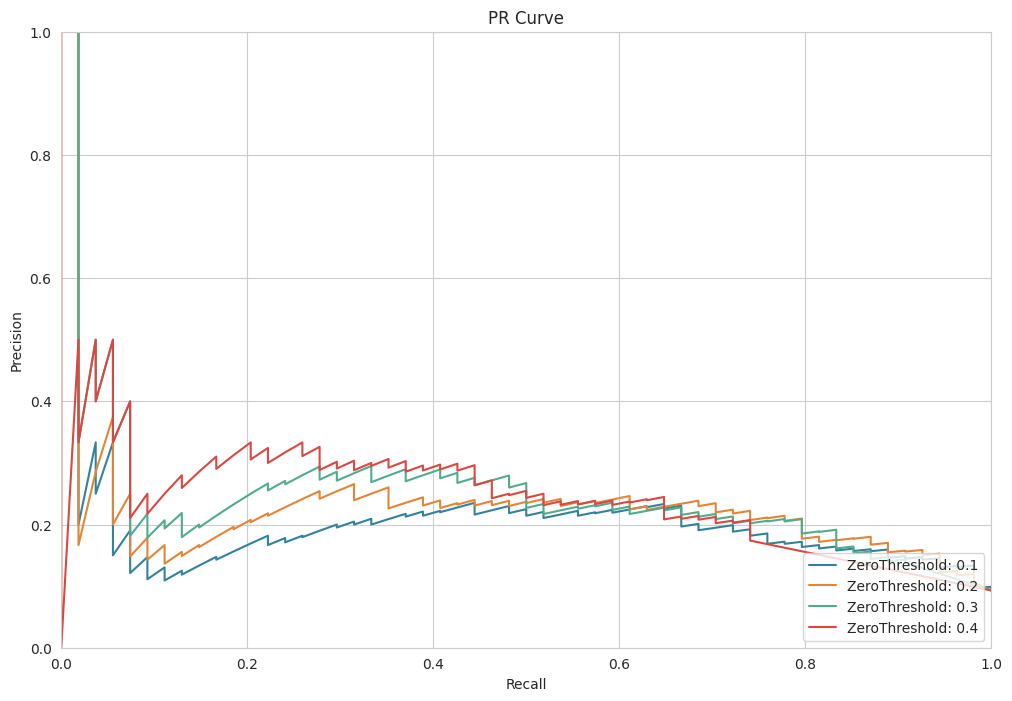

In [9]:
plt.figure(figsize = (12,8)) 
for i in range (zeroThresholdArr.shape[0]):
    precision, recall, thresholds = precision_recall_curve(lblVals, sumVals[:, i])
    plt.plot(recall, precision, label=f'ZeroThreshold: {zeroThresholdArr[i]:0.1f}')

plt.margins(0)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve')
plt.legend(loc="lower right") 
plt.show()

# Evaluate different settings

In [5]:
#TODO: include camerProps

def evaluateAndPlotSettings(settings: [dict], checkPoint = None):
    unnorm = UnNormalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    if checkPoint is None:
        checkPoint = '/data/tim/heronWorkspace/logs/CAEV1/version_3/checkpoints/epoch=49-step=19350.ckpt'
    caeLoaded = CAEHeron.load_from_checkpoint(checkPoint, model = model)
    caeLoaded.freeze()
    negVals = {
            "mean": [],
            "std": [],
            "min": [],
            "max": [],
            "median": [],
        }
    posVals = {
        "mean": [],
        "std": [],
        "min": [],
        "max": [],
        "median": [],
    }
    recallArr = []
    precisionArr = []
    imagePaths = []
    allVals = []
    for settingNr, params in enumerate(settings):
        dataset = DatasetThreeConsecutive(cameras=params["cameras"], resize_to=CAEV1.imsize, **loaderParams)
        print(f'Length of dataset: {len(dataset)}')
        print(params)
        dataLoader = DataLoader(dataset, batch_size=8, shuffle=False, num_workers=2)

        blur = GaussianBlur(kernel_size=params["gaussianFilterSize"], sigma=params["gaussianFilterSigma"]) #TODO: make this a parameter
        lossFn = F.mse_loss if params["lossFn"] == "MSE" else F.l1_loss
        vals = []
        for (imArr, lblArr, camera, ImagePath) in dataLoader:
            isTrainingCamera = camera in caeLoaded.hparams.cameras
            prevImg = imArr[0] #alwasy #batch_size images
            currImg = imArr[1]
            nextImg = imArr[2]

            prevPred, currPred, nextPred = [unnorm(caeLoaded(x.to(caeLoaded.device))) for x in [prevImg, currImg, nextImg]]
            prevImg, currImg, nextImg = [unnorm(x) for x in [prevImg, currImg, nextImg]]


            prevImgBlurred, currImgBlurred, nextImgBlurred = [blur.forward(x).to(prevPred.device) for x in [prevImg, currImg, nextImg]]
        
            
            prevImd, currImd, nextImd = [torch.sum(lossFn(imgBlurred, pred, reduction='none'), dim=1) for imgBlurred, pred in zip([prevImgBlurred, currImgBlurred, nextImgBlurred], [prevPred, currPred, nextPred])]

            prevToCurrImd = torch.clamp(torch.sub(currImd, prevImd), min= 0)
            nextToCurrImd = torch.clamp(torch.sub(currImd, nextImd), min= 0)

            prevNextCurrImd = torch.div(torch.add(prevToCurrImd, nextToCurrImd), 2)

            prevNextCurrImdMin = torch.stack([min_filter(x, kernel_size=params["minFilterKernelSize"]) for x in prevNextCurrImd]) #TODO: evtl make this as before
            

            prevNextCurrImdMinThresh = torch.where(prevNextCurrImdMin < params["zeroThreshold"], torch.zeros_like(prevNextCurrImdMin), prevNextCurrImdMin)
            

            sumPrevNextCurrImdMin = torch.sum(prevNextCurrImdMinThresh, dim=(1, 2))
            predictions = (sumPrevNextCurrImdMin> params["sumThreshold"]).to(torch.int)


            for i in range(len(predictions)):
                vals.append([lblArr[i].item(), predictions[i].item(), sumPrevNextCurrImdMin[i].item(), settingNr])
        
            imagePaths += list(ImagePath)
        vals = np.array(vals)
        
        imagePaths = np.array(imagePaths, dtype=object)

        confMat = confusion_matrix(vals[:, 0], vals[:,1])
        fig= plt.figure(figsize = (6,3))
        ax = fig.add_subplot(111)
        sns.heatmap(confMat, annot=True)
        plt.gca().collections[0].set_clim(0, len(dataset)/2)
        ax.set_xlabel('Pred', fontsize=12)
        ax.set_ylabel('True', fontsize=12)
        onlyPos = vals[vals[:, 0] == 1]
        onlyNeg = vals[vals[:, 0] == 0]
        print(f'mean pos: {np.mean(onlyPos[:, 2])}, std pos: {np.std(onlyPos[:, 2])}')
        print(f'mean neg: {np.mean(onlyNeg[:, 2])}, std neg: {np.std(onlyNeg[:, 2])}')
        print(f'median pos: {np.median(onlyPos[:, 2])}, median neg: {np.median(onlyNeg[:, 2])}')
        print(f'lowest pos: {np.min(onlyPos[:, 2])}, highest pos: {np.max(onlyPos[:, 2])}')
        print(f'lowest neg: {np.min(onlyNeg[:, 2])}, highest neg: {np.max(onlyNeg[:, 2])}')

        posVals["mean"].append(np.mean(onlyPos[:, 2]))
        posVals["std"].append(np.std(onlyPos[:, 2]))
        posVals["min"].append(np.min(onlyPos[:, 2]))
        posVals["max"].append(np.max(onlyPos[:, 2]))
        posVals["median"].append(np.median(onlyPos[:, 2]))

        negVals["mean"].append(np.mean(onlyNeg[:, 2]))
        negVals["std"].append(np.std(onlyNeg[:, 2]))
        negVals["min"].append(np.min(onlyNeg[:, 2]))
        negVals["max"].append(np.max(onlyNeg[:, 2]))
        negVals["median"].append(np.median(onlyNeg[:, 2]))

        recallArr.append(recall_score(vals[:, 0], vals[:,1]))
        precisionArr.append(precision_score(vals[:, 0], vals[:,1]))

        print(f'accuracy: {accuracy_score(vals[:, 0], vals[:,1])}')
        print(f'precision: {precision_score(vals[:, 0], vals[:,1])}')
        print(f'recall: {recall_score(vals[:, 0], vals[:,1])}')
        print(f'f1: {f1_score(vals[:, 0], vals[:,1])}')
        plt.show()

        sortInds = (-vals[:, 2]).argsort()
        vals = vals[sortInds]
        imagePaths = imagePaths[sortInds]
        # scatter plot
        scat = sns.scatterplot(x=range(len(vals)), y=vals[:, 2], hue=vals[:, 0])
        scat.axhline(params["sumThreshold"], color="#EBC556")
        scat.set_title('Sorted Sum of pixel values')
        scat.set_xlabel('rank')
        scat.set_ylabel('sum of pixel values')
        scat.legend(title="True Label")
        plt.show()

        # image plot
        fig, ax = plt.subplots(2, 4, figsize=(30, 12))
        fig.tight_layout(h_pad=0.1, w_pad=0.1)
        for i in range(4):
            posImagePath = imagePaths[i]
            negImagePath = imagePaths[-(i+1)]
            ax[0, i].imshow(Image.open(f"/data/shared/herons/TinaDubach_data/{posImagePath.split('_')[1]}/{posImagePath}.JPG"))
            ax[0, i].set_title(f"rank {i+1} ({posImagePath.split('_')[1]}) True: {vals[i, 0]}")
            ax[1, i].imshow(Image.open(f"/data/shared/herons/TinaDubach_data/{negImagePath.split('_')[1]}/{negImagePath}.JPG"))
            ax[1, i].set_title(f"rank {len(vals)-i} ({negImagePath.split('_')[1]}) True: {vals[-(i+1), 0]}")

        for i in range(len(ax)):
            for j in range(len(ax[i])):
                ax[i][j].set_xticks([])
                ax[i][j].set_yticks([])
        plt.show()
        
        allVals.append(vals)
        vals = []
        imagePaths = []

    # mean/std plot
    # fig = plt.figure(figsize = (len(params),3))
    # plt.errorbar([i-0.1 for i in range(len(posVals["mean"]))], posVals["mean"], yerr=posVals["std"],fmt='.k', capsize=5, label="pos (mean and std)")
    # plt.errorbar([i+0.1 for i in range(len(negVals["mean"]))], negVals["mean"], yerr=negVals["std"],fmt='.k', capsize=5, label="neg (mean and std)")
    # plt.plot([i-0.1 for i in range(len(posVals["mean"]))], posVals["median"], '*', color="black", label="median")
    # plt.plot([i+0.1 for i in range(len(negVals["mean"]))], negVals["median"], '*', color="black")

    # for i in range(len(recallArr)):
    #     plt.text(i, np.max([(posVals["mean"][i] + posVals["std"][i]), (negVals["mean"][i] + negVals["std"][i])]) + 10, f'recall = {recallArr[i]:.2f}\nprecision = {precisionArr[i]:.2f}', fontsize=8, ha='center')

    # plt.xticks(range(len(settings)))
    # plt.xlabel("setting")
    # plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05))
    # plt.show()

    # boxplot
    fig, ax = plt.subplots(1, 1, figsize=(30, 20))
    allVals = np.array(allVals).reshape((-1, 4))
    df = pd.DataFrame(data = allVals[:], columns=["trueLbl", "predLbl", "sumOfPixelValues", "settingNr"])
    boxPlt = sns.boxplot(data = df, x= "settingNr", y="sumOfPixelValues", hue="trueLbl", gap=.1, ax=ax)
    boxPlt.set_xticklabels([f'r= {recallArr[i]:.2f}\np= {precisionArr[i]:.2f}' for i in range(len(recallArr))], fontsize=6)
    boxPlt.set_xlabel("setting")
    # boxPlt.set_ylim(0, None)
    # for i in range(len(recallArr)):
    #     plt.text(i, 0.1, f'recall = {recallArr[i]:.2f}\nprecision = {precisionArr[i]:.2f}', fontsize=8, ha='center')
    plt.show()


## min Filter

In [ ]:
loaderParams = dict(
    lblValidationMode = "Manual",
    balanced = True,
    anomalyObviousness = "obvious",
    distinctCAETraining = False,
    colorMode = "RGB",
    random_state = 1,
    set = "train"
)
startState = dict(
    cameras = ["NEN1", "SBU3"], #, ["SBU4"]
    balanced = True,
    distinctCAETraining = False,
    gaussianFilterSize = 5,
    gaussianFilterSigma = 5,
    filter = "MinFilter", #["MinFilter", "GaussianFilter"]
    minFilterKernelSize = 3,
    zeroThreshold = 0.175, # uniform dist on loc, loc+scale -> uniform(loc, scale) #threshold for zeroing out the image
    sumThreshold = 50.9,
    lossFn = "L1"
)

kernelSizeArr = [2, 3, 4]
settings = [dict(startState, minFilterKernelSize=kernelSize) for kernelSize in kernelSizeArr]
evaluateAndPlotSettings(settings)